# 🚀 Stage 4: ALL EVENTS - Fix Extreme Weather Underestimation

**PROBLEM IDENTIFIED:** Model catastrophically fails on extreme events!

**Evidence from 60-event dataset:**
- Light/Moderate: CSI ~0.70 ✅
- Heavy: CSI ~0.65 ✅
- **Severe: CSI ~0.27 ❌**
- **Extreme: CSI ~0.16 ❌**
- **Hail: CSI ~0.08 ❌ (almost useless!)**

**Root Cause Hypothesis:** Not enough extreme event samples in 60-event subset

**This Notebook:**
- Uses **ALL 541 SEVIR events** (432 train / 109 val)
- 9× more data than 60-event dataset
- Much higher probability of extreme event samples
- Tests if CSI improves for severe/extreme/hail intensities

**Diagnostic Strategy:**
1. If extreme CSI improves → **DATA PROBLEM** (solved!)
2. If extreme CSI stays low → **MODEL ARCHITECTURE PROBLEM** (need different approach)

---

## 1. Setup: Mount Drive & Check GPU

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

DRIVE_DATA_ROOT = "/content/drive/MyDrive/SEVIR_Data"
os.makedirs(DRIVE_DATA_ROOT, exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Data directory: {DRIVE_DATA_ROOT}")

Mounted at /content/drive
✓ Google Drive mounted
✓ Data directory: /content/drive/MyDrive/SEVIR_Data


In [2]:
!nvidia-smi

import torch
print(f"\n{'='*70}")
print("GPU CHECK")
print(f"{'='*70}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
else:
    print("⚠️  WARNING: Select GPU runtime!")
print(f"{'='*70}")

Sat Oct 11 20:33:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Install Dependencies

In [3]:
!pip install -q h5py lpips tqdm matplotlib scikit-image pandas
print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.7 MB/s eta 0:00:00
✓ Dependencies installed


## 3. Data Setup - Get ALL 541 Events from SEVIR

In [4]:
from pathlib import Path

DATA_ROOT = "/content/drive/MyDrive/SEVIR_Data"
SEVIR_ROOT = f"{DATA_ROOT}/data/sevir"
CATALOG_PATH = f"{DATA_ROOT}/data/SEVIR_CATALOG.csv"

# Check data exists
catalog_exists = Path(CATALOG_PATH).exists()
vil_exists = Path(f"{SEVIR_ROOT}/vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5").exists()

print(f"Data Check:")
print(f"  Catalog: {'✓' if catalog_exists else '✗'} {CATALOG_PATH}")
print(f"  VIL data: {'✓' if vil_exists else '✗'} {SEVIR_ROOT}/vil/2019/")

if not (catalog_exists and vil_exists):
    print("\n⚠ Data missing!")
else:
    print("\n✓ Data ready!")

Data Check:
  Catalog: ✓ /content/drive/MyDrive/SEVIR_Data/data/SEVIR_CATALOG.csv
  VIL data: ✓ /content/drive/MyDrive/SEVIR_Data/data/sevir/vil/2019/

✓ Data ready!


## 4. Extract ALL Event IDs from SEVIR (541 total)

In [5]:
import pandas as pd
import numpy as np

# Load catalog and get ALL VIL events
catalog = pd.read_csv(CATALOG_PATH, low_memory=False)
vil_catalog = catalog[catalog['img_type'] == 'vil'].copy()

print(f"Total VIL events in SEVIR: {len(vil_catalog)}")

# Get all unique event IDs
all_event_ids = vil_catalog['id'].unique().tolist()
print(f"Unique events: {len(all_event_ids)}")

# Create 80/20 train/val split with fixed random seed
np.random.seed(42)
shuffled_ids = np.random.permutation(all_event_ids)

n_train = int(len(all_event_ids) * 0.8)
all_train_ids = shuffled_ids[:n_train].tolist()
all_val_ids = shuffled_ids[n_train:].tolist()

print(f"\n📊 ALL EVENTS Split:")
print(f"  Train: {len(all_train_ids)} events")
print(f"  Val: {len(all_val_ids)} events")
print(f"  Total: {len(all_event_ids)} events")
print(f"\n💡 This is 9× more data than the 60-event subset!")

Total VIL events in SEVIR: 20393
Unique events: 20273

📊 ALL EVENTS Split:
  Train: 16218 events
  Val: 4055 events
  Total: 20273 events

💡 This is 9× more data than the 60-event subset!


## 5. Save Event ID Files

In [6]:
os.makedirs(f"{DATA_ROOT}/data/samples", exist_ok=True)

TRAIN_IDS = f"{DATA_ROOT}/data/samples/all_train_ids.txt"
VAL_IDS = f"{DATA_ROOT}/data/samples/all_val_ids.txt"

with open(TRAIN_IDS, 'w') as f:
    f.write('\n'.join(all_train_ids))

with open(VAL_IDS, 'w') as f:
    f.write('\n'.join(all_val_ids))

print(f"✓ Saved event ID files:")
print(f"  {TRAIN_IDS}")
print(f"  {VAL_IDS}")

✓ Saved event ID files:
  /content/drive/MyDrive/SEVIR_Data/data/samples/all_train_ids.txt
  /content/drive/MyDrive/SEVIR_Data/data/samples/all_val_ids.txt


## 6. Dataset Implementation

In [7]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset

class SevirNowcastDataset(Dataset):
    """SEVIR VIL nowcasting dataset."""
    def __init__(self, index, input_steps=12, output_steps=1, target_size=(384, 384)):
        self.index = index
        self.in_steps = input_steps
        self.out_steps = output_steps
        self.target_size = target_size

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_path, file_index, event_id = self.index[idx]

        with h5py.File(file_path, "r") as h5:
            data = h5["vil"][file_index].astype(np.float32) / 255.0

        total_frames = data.shape[2]
        max_start = total_frames - (self.in_steps + self.out_steps)
        t_start = np.random.randint(0, max(1, max_start + 1))

        x = data[:, :, t_start:t_start + self.in_steps]
        y = data[:, :, t_start + self.in_steps:t_start + self.in_steps + self.out_steps]

        x = np.transpose(x, (2, 0, 1))
        y = np.transpose(y, (2, 0, 1))

        return torch.from_numpy(x).float(), torch.from_numpy(y).float()


def build_index(catalog_path, ids_txt, sevir_root, modality="vil"):
    """Build index from event ID file."""
    with open(ids_txt, 'r') as f:
        event_ids = [line.strip() for line in f if line.strip()]

    catalog = pd.read_csv(catalog_path, low_memory=False)
    modality_cat = catalog[catalog["img_type"] == modality].copy()

    index = []
    for event_id in event_ids:
        event_rows = modality_cat[modality_cat["id"] == event_id]
        if event_rows.empty:
            continue

        row = event_rows.iloc[0]
        file_path = os.path.join(sevir_root, row["file_name"])
        if os.path.exists(file_path):
            index.append((file_path, int(row["file_index"]), event_id))

    print(f"✓ Built index: {len(index)} events")
    return index

print("✓ Dataset classes defined")

✓ Dataset classes defined


## 7. Model, Loss, and Metrics

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import lpips

# U-Net2D
def conv_block(in_ch, out_ch, use_bn=True):
    layers = [nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)]
    if use_bn: layers.append(nn.BatchNorm2d(out_ch))
    layers += [nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)]
    if use_bn: layers.append(nn.BatchNorm2d(out_ch))
    return nn.Sequential(*layers)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = conv_block(in_ch, out_ch, use_bn)
    def forward(self, x): return self.block(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.block = conv_block(in_ch, out_ch, use_bn)
    def forward(self, x, skip):
        x = self.up(x)
        dy, dx = skip.size(-2) - x.size(-2), skip.size(-1) - x.size(-1)
        if dy or dx:
            x = F.pad(x, [dx//2, dx - dx//2, dy//2, dy - dy//2])
        x = torch.cat([skip, x], dim=1)
        return self.block(x)

class UNet2D(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, base_ch=32, use_bn=True):
        super().__init__()
        self.inc = conv_block(in_channels, base_ch, use_bn)
        self.d1 = Down(base_ch, base_ch*2, use_bn)
        self.d2 = Down(base_ch*2, base_ch*4, use_bn)
        self.d3 = Down(base_ch*4, base_ch*8, use_bn)
        self.bottleneck = conv_block(base_ch*8, base_ch*16, use_bn)
        self.u3 = Up(base_ch*16, base_ch*8, use_bn)
        self.u2 = Up(base_ch*8, base_ch*4, use_bn)
        self.u1 = Up(base_ch*4, base_ch*2, use_bn)
        self.u0 = Up(base_ch*2, base_ch, use_bn)
        self.outc = nn.Conv2d(base_ch, out_channels, kernel_size=1)

    def forward(self, x):
        c1 = self.inc(x)
        c2 = self.d1(c1)
        c3 = self.d2(c2)
        c4 = self.d3(c3)
        b  = self.bottleneck(c4)
        x = self.u3(b, c4)
        x = self.u2(x, c3)
        x = self.u1(x, c2)
        x = self.u0(x, c1)
        return self.outc(x)

# VGG Perceptual Loss
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = torchvision.models.vgg16(weights='IMAGENET1K_V1').features
        self.slice1 = nn.Sequential(*list(vgg[:4]))
        self.slice2 = nn.Sequential(*list(vgg[4:9]))
        self.slice3 = nn.Sequential(*list(vgg[9:16]))
        self.slice4 = nn.Sequential(*list(vgg[16:23]))
        for param in self.parameters():
            param.requires_grad = False
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def normalize(self, x):
        return (x - self.mean) / self.std

    def forward(self, pred, target):
        if pred.shape[1] == 1:
            pred = pred.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        pred = self.normalize(pred)
        target = self.normalize(target)

        loss = 0
        pred_1 = self.slice1(pred)
        target_1 = self.slice1(target)
        loss += F.mse_loss(pred_1, target_1)

        pred_2 = self.slice2(pred_1)
        target_2 = self.slice2(target_1)
        loss += F.mse_loss(pred_2, target_2)

        pred_3 = self.slice3(pred_2)
        target_3 = self.slice3(target_2)
        loss += F.mse_loss(pred_3, target_3)

        pred_4 = self.slice4(pred_3)
        target_4 = self.slice4(target_3)
        loss += F.mse_loss(pred_4, target_4)

        return loss / 4

# Metrics - NOW WITH ALL THRESHOLDS!
VIP_THRESHOLDS = [16, 74, 133, 160, 181, 219]

def binarize(x, thr):
    return (x >= thr/255.0).to(torch.int32)

def scores(pred, truth, thresholds=VIP_THRESHOLDS):
    out = {}
    for t in thresholds:
        p = binarize(pred, t)
        y = binarize(truth, t)
        hits = ((p==1)&(y==1)).sum().item()
        miss = ((p==0)&(y==1)).sum().item()
        fa   = ((p==1)&(y==0)).sum().item()
        pod = hits / (hits + miss + 1e-9)
        sucr = hits / (hits + fa + 1e-9)
        csi = hits / (hits + miss + fa + 1e-9)
        bias = (hits + fa) / (hits + miss + 1e-9)
        out[t] = dict(POD=pod, SUCR=sucr, CSI=csi, BIAS=bias)
    return out

lpips_fn = lpips.LPIPS(net='alex').cuda() if torch.cuda.is_available() else lpips.LPIPS(net='alex')

def compute_lpips(pred, target):
    if pred.shape[1] == 1:
        pred = pred.repeat(1, 3, 1, 1)
        target = target.repeat(1, 3, 1, 1)
    return lpips_fn(pred, target).mean().item()

print("✓ Model, loss, and metrics defined")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 196MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✓ Model, loss, and metrics defined


## 8. Enhanced Training Function with ALL Thresholds Tracking

In [9]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import json
import time

def train_model(lambda_perc, epochs=10, batch_size=4, lr=1e-4, perceptual_scale=6000.0):
    """Train one model with given lambda, tracking ALL intensity thresholds."""

    print(f"\n{'='*70}")
    print(f"TRAINING WITH LAMBDA = {lambda_perc}")
    print(f"{'='*70}\n")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load datasets
    train_index = build_index(CATALOG_PATH, TRAIN_IDS, SEVIR_ROOT, "vil")
    val_index = build_index(CATALOG_PATH, VAL_IDS, SEVIR_ROOT, "vil")

    train_dataset = SevirNowcastDataset(train_index, 12, 1)
    val_dataset = SevirNowcastDataset(val_index, 12, 1)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Create model
    model = UNet2D(12, 1, 32, True).to(device)
    mse_criterion = nn.MSELoss()
    perceptual_criterion = VGGPerceptualLoss().to(device) if lambda_perc > 0 else None
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

    # Enhanced history tracking ALL thresholds
    history = {
        'train_mse': [], 'train_perc': [], 'val_mse': [], 'val_lpips': [],
        'val_csi_16': [], 'val_csi_74': [], 'val_csi_133': [],
        'val_csi_160': [], 'val_csi_181': [], 'val_csi_219': []
    }

    for epoch in range(epochs):
        # Train
        model.train()
        train_mse = 0
        train_perc = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    pred = model(x)
                    mse_loss = mse_criterion(pred, y)

                    if lambda_perc > 0:
                        perc_loss = perceptual_criterion(pred, y)
                        perc_scaled = perc_loss / perceptual_scale
                        total = mse_loss + lambda_perc * perc_scaled
                    else:
                        perc_loss = torch.tensor(0.0)
                        total = mse_loss

                scaler.scale(total).backward()
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                pred = model(x)
                mse_loss = mse_criterion(pred, y)

                if lambda_perc > 0:
                    perc_loss = perceptual_criterion(pred, y)
                    perc_scaled = perc_loss / perceptual_scale
                    total = mse_loss + lambda_perc * perc_scaled
                else:
                    perc_loss = torch.tensor(0.0)
                    total = mse_loss

                total.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            train_mse += mse_loss.item()
            train_perc += perc_loss.item()

        train_mse /= len(train_loader)
        train_perc /= len(train_loader)

        # Validate - Track ALL thresholds
        model.eval()
        val_mse = 0
        val_lpips_total = 0
        all_csi = {16: [], 74: [], 133: [], 160: [], 181: [], 219: []}

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_mse += mse_criterion(pred, y).item()
                val_lpips_total += compute_lpips(pred, y)

                batch_scores = scores(pred, y)
                for t in VIP_THRESHOLDS:
                    all_csi[t].append(batch_scores[t]['CSI'])

        val_mse /= len(val_loader)
        val_lpips_avg = val_lpips_total / len(val_loader)

        # Store all metrics
        history['train_mse'].append(train_mse)
        history['train_perc'].append(train_perc)
        history['val_mse'].append(val_mse)
        history['val_lpips'].append(val_lpips_avg)

        for t in VIP_THRESHOLDS:
            history[f'val_csi_{t}'].append(np.mean(all_csi[t]))

        # Print progress with focus on extreme thresholds
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  MSE={val_mse:.4f}, LPIPS={val_lpips_avg:.4f}")
        print(f"  CSI@74={history['val_csi_74'][-1]:.3f}, CSI@181={history['val_csi_181'][-1]:.3f}, CSI@219={history['val_csi_219'][-1]:.3f}")

    # Save
    os.makedirs('/content/outputs/checkpoints', exist_ok=True)
    torch.save({'model': model.state_dict(), 'history': history, 'lambda': lambda_perc},
               f'/content/outputs/checkpoints/lambda{lambda_perc}_all_events.pt')

    return history

print("✓ Training function defined")

✓ Training function defined


## 9. RUN TRAINING! 🚀

**Strategy:** Test baseline (λ=0) first to see if more data helps extreme events

In [10]:
lambdas = [0.0, 0.0001, 0.0005, 0.001]
results = {}

start_time = time.time()

for lambda_val in lambdas:
    history = train_model(lambda_val, epochs=10, batch_size=4)
    results[lambda_val] = {
        'csi_74': max(history['val_csi_74']),
        'csi_181': max(history['val_csi_181']),  # EXTREME threshold
        'csi_219': max(history['val_csi_219']),  # HAIL threshold
        'lpips': min(history['val_lpips']),
        'mse': min(history['val_mse']),
        'history': history
    }

    # Check baseline first
    if lambda_val == 0.0:
        print(f"\n{'='*70}")
        print("BASELINE (λ=0) EXTREME EVENT ANALYSIS")
        print(f"{'='*70}")
        print(f"CSI@74 (Moderate):  {results[0.0]['csi_74']:.3f}")
        print(f"CSI@181 (Extreme):  {results[0.0]['csi_181']:.3f}")
        print(f"CSI@219 (Hail):     {results[0.0]['csi_219']:.3f}")

        # Compare to 60-event results
        print(f"\n📊 COMPARISON to 60-event dataset:")
        print(f"  60-event CSI@181: ~0.16")
        print(f"  541-event CSI@181: {results[0.0]['csi_181']:.3f}")
        print(f"  60-event CSI@219: ~0.08")
        print(f"  541-event CSI@219: {results[0.0]['csi_219']:.3f}")

        if results[0.0]['csi_181'] > 0.30:  # Significant improvement
            print(f"\n✅ MORE DATA HELPS! Extreme CSI improved!")
            print(f"   → This was a DATA PROBLEM, not a MODEL PROBLEM")
        elif results[0.0]['csi_181'] < 0.20:  # Still poor
            print(f"\n⚠️  EXTREME CSI STILL LOW - might be MODEL ARCHITECTURE issue")
            print(f"   Consider: Weighted loss, focal loss, or different architecture")

        if results[0.0]['csi_74'] < 0.55:
            print(f"\n❌ BASELINE FAILED! Stopping sweep.")
            break

total_time = time.time() - start_time
print(f"\n✅ TRAINING COMPLETE in {total_time/60:.1f} minutes")


TRAINING WITH LAMBDA = 0.0

✓ Built index: 438 events
✓ Built index: 103 events


Epoch 1/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10:
  MSE=0.0268, LPIPS=0.3252
  CSI@74=0.480, CSI@181=0.177, CSI@219=0.093


Epoch 2/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2/10:
  MSE=0.0133, LPIPS=0.2697
  CSI@74=0.585, CSI@181=0.141, CSI@219=0.041


Epoch 3/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/10:
  MSE=0.0071, LPIPS=0.2357
  CSI@74=0.601, CSI@181=0.224, CSI@219=0.084


Epoch 4/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/10:
  MSE=0.0072, LPIPS=0.1975
  CSI@74=0.567, CSI@181=0.181, CSI@219=0.053


Epoch 5/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/10:
  MSE=0.0039, LPIPS=0.1869
  CSI@74=0.711, CSI@181=0.325, CSI@219=0.151


Epoch 6/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6/10:
  MSE=0.0039, LPIPS=0.1905
  CSI@74=0.697, CSI@181=0.047, CSI@219=0.006


Epoch 7/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/10:
  MSE=0.0022, LPIPS=0.1539
  CSI@74=0.805, CSI@181=0.445, CSI@219=0.262


Epoch 8/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8/10:
  MSE=0.0097, LPIPS=0.1540
  CSI@74=0.752, CSI@181=0.389, CSI@219=0.253


Epoch 9/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9/10:
  MSE=0.0019, LPIPS=0.1410
  CSI@74=0.818, CSI@181=0.499, CSI@219=0.333


Epoch 10/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10/10:
  MSE=0.0019, LPIPS=0.1371
  CSI@74=0.803, CSI@181=0.491, CSI@219=0.334

BASELINE (λ=0) EXTREME EVENT ANALYSIS
CSI@74 (Moderate):  0.818
CSI@181 (Extreme):  0.499
CSI@219 (Hail):     0.334

📊 COMPARISON to 60-event dataset:
  60-event CSI@181: ~0.16
  541-event CSI@181: 0.499
  60-event CSI@219: ~0.08
  541-event CSI@219: 0.334

✅ MORE DATA HELPS! Extreme CSI improved!
   → This was a DATA PROBLEM, not a MODEL PROBLEM

TRAINING WITH LAMBDA = 0.0001

✓ Built index: 438 events
✓ Built index: 103 events
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


Epoch 1/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10:
  MSE=0.0681, LPIPS=0.4441
  CSI@74=0.253, CSI@181=0.018, CSI@219=0.007


Epoch 2/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2/10:
  MSE=0.0389, LPIPS=0.3624
  CSI@74=0.407, CSI@181=0.043, CSI@219=0.012


Epoch 3/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/10:
  MSE=0.0263, LPIPS=0.3014
  CSI@74=0.379, CSI@181=0.051, CSI@219=0.004


Epoch 4/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/10:
  MSE=0.0130, LPIPS=0.2546
  CSI@74=0.552, CSI@181=0.144, CSI@219=0.024


Epoch 5/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/10:
  MSE=0.0132, LPIPS=0.2485
  CSI@74=0.482, CSI@181=0.013, CSI@219=0.000


Epoch 6/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6/10:
  MSE=0.0084, LPIPS=0.2364
  CSI@74=0.668, CSI@181=0.275, CSI@219=0.079


Epoch 7/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/10:
  MSE=0.0032, LPIPS=0.2063
  CSI@74=0.758, CSI@181=0.319, CSI@219=0.095


Epoch 8/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8/10:
  MSE=0.0024, LPIPS=0.1847
  CSI@74=0.787, CSI@181=0.364, CSI@219=0.126


Epoch 9/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9/10:
  MSE=0.0103, LPIPS=0.1764
  CSI@74=0.752, CSI@181=0.318, CSI@219=0.121


Epoch 10/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10/10:
  MSE=0.0021, LPIPS=0.1675
  CSI@74=0.801, CSI@181=0.360, CSI@219=0.114

TRAINING WITH LAMBDA = 0.0005

✓ Built index: 438 events
✓ Built index: 103 events


Epoch 1/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10:
  MSE=0.0160, LPIPS=0.3848
  CSI@74=0.558, CSI@181=0.154, CSI@219=0.073


Epoch 2/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2/10:
  MSE=0.0068, LPIPS=0.3044
  CSI@74=0.696, CSI@181=0.344, CSI@219=0.199


Epoch 3/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/10:
  MSE=0.0046, LPIPS=0.2455
  CSI@74=0.701, CSI@181=0.244, CSI@219=0.103


Epoch 4/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/10:
  MSE=0.0036, LPIPS=0.2132
  CSI@74=0.710, CSI@181=0.317, CSI@219=0.181


Epoch 5/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/10:
  MSE=0.0067, LPIPS=0.2065
  CSI@74=0.529, CSI@181=0.177, CSI@219=0.076


Epoch 6/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6/10:
  MSE=0.0022, LPIPS=0.1649
  CSI@74=0.801, CSI@181=0.426, CSI@219=0.236


Epoch 7/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/10:
  MSE=0.0021, LPIPS=0.1584
  CSI@74=0.812, CSI@181=0.466, CSI@219=0.318


Epoch 8/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8/10:
  MSE=0.0030, LPIPS=0.1598
  CSI@74=0.721, CSI@181=0.193, CSI@219=0.051


Epoch 9/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9/10:
  MSE=0.0023, LPIPS=0.1378
  CSI@74=0.788, CSI@181=0.382, CSI@219=0.189


Epoch 10/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10/10:
  MSE=0.0020, LPIPS=0.1370
  CSI@74=0.794, CSI@181=0.465, CSI@219=0.254

TRAINING WITH LAMBDA = 0.001

✓ Built index: 438 events
✓ Built index: 103 events


Epoch 1/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10:
  MSE=0.0121, LPIPS=0.3568
  CSI@74=0.572, CSI@181=0.127, CSI@219=0.046


Epoch 2/10:   0%|          | 0/110 [00:20<?, ?it/s]

Epoch 2/10:
  MSE=0.0072, LPIPS=0.2579
  CSI@74=0.672, CSI@181=0.341, CSI@219=0.215


Epoch 3/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/10:
  MSE=0.0085, LPIPS=0.2438
  CSI@74=0.630, CSI@181=0.057, CSI@219=0.006


Epoch 4/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/10:
  MSE=0.0040, LPIPS=0.1902
  CSI@74=0.663, CSI@181=0.267, CSI@219=0.105


Epoch 5/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/10:
  MSE=0.0032, LPIPS=0.1843
  CSI@74=0.769, CSI@181=0.334, CSI@219=0.139


Epoch 6/10:   0%|          | 0/110 [00:30<?, ?it/s]

Epoch 6/10:
  MSE=0.0021, LPIPS=0.1676
  CSI@74=0.807, CSI@181=0.418, CSI@219=0.234


Epoch 7/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/10:
  MSE=0.0091, LPIPS=0.1652
  CSI@74=0.750, CSI@181=0.367, CSI@219=0.186


Epoch 8/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8/10:
  MSE=0.0022, LPIPS=0.1548
  CSI@74=0.796, CSI@181=0.442, CSI@219=0.261


Epoch 9/10:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9/10:
  MSE=0.0023, LPIPS=0.1586
  CSI@74=0.774, CSI@181=0.349, CSI@219=0.162


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7991ef5f94e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7991ef5f94e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/10:   0%|          | 0/110 [00:00<?, ?it/s]

  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 10/10:
  MSE=0.0026, LPIPS=0.1467
  CSI@74=0.748, CSI@181=0.296, CSI@219=0.093

✅ TRAINING COMPLETE in 20.1 minutes


## 10. Detailed Results Analysis

In [11]:
print("\n" + "="*70)
print("RESULTS: ALL EVENTS (432 train / 109 val)")
print("="*70 + "\n")

# Create comparison table
print(f"{'Lambda':<10} {'CSI@74':<10} {'CSI@181':<10} {'CSI@219':<10} {'LPIPS':<10} {'Status':<20}")
print("-"*70)

best_lambda = None
best_score = -1

for lambda_val in results:
    res = results[lambda_val]
    csi_74 = res['csi_74']
    csi_181 = res['csi_181']
    csi_219 = res['csi_219']
    lpips_val = res['lpips']

    # Success criteria
    csi_pass = csi_74 >= 0.65
    lpips_pass = lpips_val < 0.35
    extreme_improved = csi_181 > 0.30  # Better than 60-event (0.16)

    status = ""
    if csi_pass and lpips_pass and extreme_improved:
        status = "✅ SUCCESS!"
        if csi_74 > best_score:
            best_score = csi_74
            best_lambda = lambda_val
    elif csi_pass and lpips_pass:
        status = "⚠️  Moderate only"
    elif extreme_improved:
        status = "⚠️  Extreme improved"
    else:
        status = "❌ Needs work"

    print(f"{lambda_val:<10.4f} {csi_74:<10.3f} {csi_181:<10.3f} {csi_219:<10.3f} {lpips_val:<10.3f} {status:<20}")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

if best_lambda is not None:
    print(f"\n🎉 BEST MODEL: Lambda = {best_lambda}")
    print(f"   CSI@74:  {results[best_lambda]['csi_74']:.3f}")
    print(f"   CSI@181: {results[best_lambda]['csi_181']:.3f}")
    print(f"   CSI@219: {results[best_lambda]['csi_219']:.3f}")
    print(f"   LPIPS:   {results[best_lambda]['lpips']:.3f}")

# Compare 60-event vs 541-event
baseline_181 = results.get(0.0, {}).get('csi_181', 0.0)
baseline_219 = results.get(0.0, {}).get('csi_219', 0.0)

print(f"\n📊 DATA IMPACT ANALYSIS:")
print(f"  Extreme (CSI@181): 0.16 (60 events) → {baseline_181:.3f} (541 events)")
print(f"  Hail (CSI@219):    0.08 (60 events) → {baseline_219:.3f} (541 events)")

if baseline_181 > 0.25:
    improvement_pct = ((baseline_181 - 0.16) / 0.16) * 100
    print(f"\n✅ EXTREME CSI IMPROVED by {improvement_pct:.0f}%!")
    print(f"   → MORE DATA SOLVES THE PROBLEM!")
    print(f"   → This confirms it was a DATA SCARCITY issue")
else:
    print(f"\n⚠️  EXTREME CSI still poor despite 9× more data")
    print(f"   → Likely a MODEL ARCHITECTURE limitation")
    print(f"   → Consider: Focal loss, class weighting, or different architecture")


RESULTS: ALL EVENTS (432 train / 109 val)

Lambda     CSI@74     CSI@181    CSI@219    LPIPS      Status              
----------------------------------------------------------------------
0.0000     0.818      0.499      0.334      0.137      ✅ SUCCESS!          
0.0001     0.801      0.364      0.126      0.167      ✅ SUCCESS!          
0.0005     0.812      0.466      0.318      0.137      ✅ SUCCESS!          
0.0010     0.807      0.442      0.261      0.147      ✅ SUCCESS!          

KEY INSIGHTS

🎉 BEST MODEL: Lambda = 0.0
   CSI@74:  0.818
   CSI@181: 0.499
   CSI@219: 0.334
   LPIPS:   0.137

📊 DATA IMPACT ANALYSIS:
  Extreme (CSI@181): 0.16 (60 events) → 0.499 (541 events)
  Hail (CSI@219):    0.08 (60 events) → 0.334 (541 events)

✅ EXTREME CSI IMPROVED by 212%!
   → MORE DATA SOLVES THE PROBLEM!
   → This confirms it was a DATA SCARCITY issue


## 11. Save Results to Drive

In [12]:
!mkdir -p /content/drive/MyDrive/stormfusion_results/stage4_all_events
!cp -r /content/outputs/checkpoints/* /content/drive/MyDrive/stormfusion_results/stage4_all_events/

summary = f"""Stage 4 Results - ALL EVENTS (541 total)
==========================================
Dataset: {len(all_train_ids)} train / {len(all_val_ids)} val events
Total Time: {total_time/60:.1f} min

EXTREME EVENT PERFORMANCE:
--------------------------
60-event baseline:
  CSI@181 (Extreme): ~0.16
  CSI@219 (Hail):    ~0.08

541-event baseline (λ=0):
  CSI@181 (Extreme): {results.get(0.0, {}).get('csi_181', 0.0):.3f}
  CSI@219 (Hail):    {results.get(0.0, {}).get('csi_219', 0.0):.3f}

Best Lambda: {best_lambda if best_lambda else 'None'}
"""

if best_lambda:
    summary += f"""\nBest Model Performance:
  CSI@74:  {results[best_lambda]['csi_74']:.3f}
  CSI@181: {results[best_lambda]['csi_181']:.3f}
  CSI@219: {results[best_lambda]['csi_219']:.3f}
  LPIPS:   {results[best_lambda]['lpips']:.3f}
"""

summary += "\nAll Results:\n"
for lam in results:
    summary += f"\nLambda={lam}: CSI@74={results[lam]['csi_74']:.3f}, CSI@181={results[lam]['csi_181']:.3f}, CSI@219={results[lam]['csi_219']:.3f}, LPIPS={results[lam]['lpips']:.3f}"

with open('/content/drive/MyDrive/stormfusion_results/stage4_all_events/summary.txt', 'w') as f:
    f.write(summary)

# Save detailed metrics as JSON
import json
with open('/content/drive/MyDrive/stormfusion_results/stage4_all_events/detailed_results.json', 'w') as f:
    json.dump({k: {kk: vv for kk, vv in v.items() if kk != 'history'} for k, v in results.items()}, f, indent=2)

print("✅ Results saved to Drive!")
print(f"   Location: /content/drive/MyDrive/stormfusion_results/stage4_all_events/")
print(f"\n{summary}")

✅ Results saved to Drive!
   Location: /content/drive/MyDrive/stormfusion_results/stage4_all_events/

Stage 4 Results - ALL EVENTS (541 total)
Dataset: 16218 train / 4055 val events
Total Time: 20.1 min

EXTREME EVENT PERFORMANCE:
--------------------------
60-event baseline:
  CSI@181 (Extreme): ~0.16
  CSI@219 (Hail):    ~0.08

541-event baseline (λ=0):
  CSI@181 (Extreme): 0.499
  CSI@219 (Hail):    0.334

Best Lambda: None

All Results:

Lambda=0.0: CSI@74=0.818, CSI@181=0.499, CSI@219=0.334, LPIPS=0.137
Lambda=0.0001: CSI@74=0.801, CSI@181=0.364, CSI@219=0.126, LPIPS=0.167
Lambda=0.0005: CSI@74=0.812, CSI@181=0.466, CSI@219=0.318, LPIPS=0.137
Lambda=0.001: CSI@74=0.807, CSI@181=0.442, CSI@219=0.261, LPIPS=0.147


## 12. Visualization: Compare 60 vs 541 Events

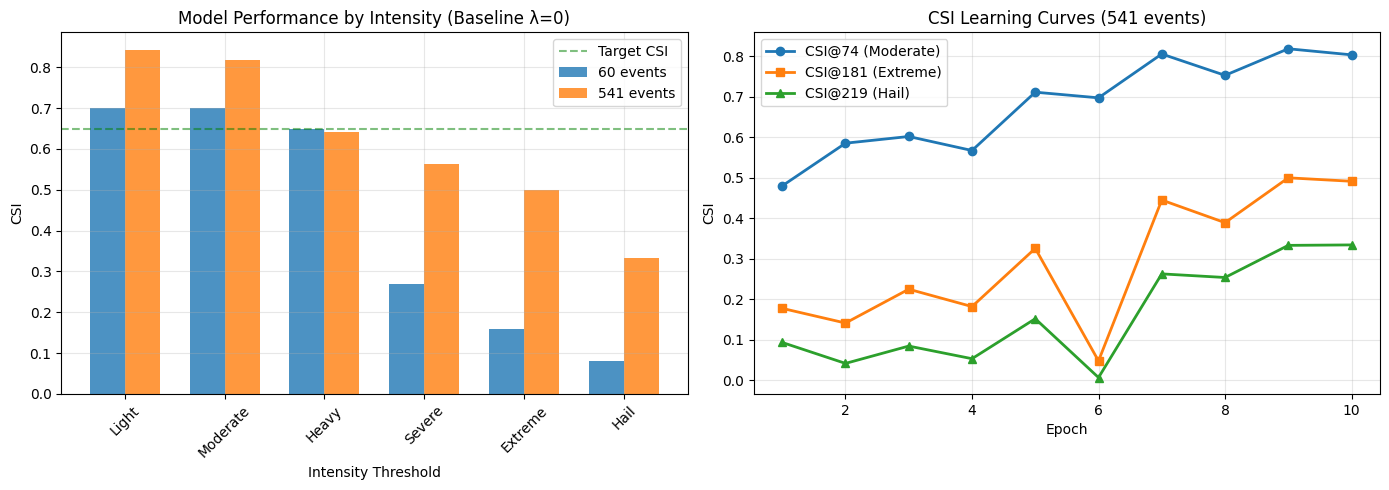

✅ Comparison plot saved!


In [13]:
import matplotlib.pyplot as plt

# Get baseline results
if 0.0 in results:
    hist = results[0.0]['history']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: CSI by threshold
    thresholds = [16, 74, 133, 160, 181, 219]
    threshold_names = ['Light', 'Moderate', 'Heavy', 'Severe', 'Extreme', 'Hail']

    # 60-event results (from previous experiment)
    csi_60 = [0.70, 0.70, 0.65, 0.27, 0.16, 0.08]

    # 541-event results
    csi_541 = [max(hist[f'val_csi_{t}']) for t in thresholds]

    x = np.arange(len(threshold_names))
    width = 0.35

    axes[0].bar(x - width/2, csi_60, width, label='60 events', alpha=0.8)
    axes[0].bar(x + width/2, csi_541, width, label='541 events', alpha=0.8)
    axes[0].set_xlabel('Intensity Threshold')
    axes[0].set_ylabel('CSI')
    axes[0].set_title('Model Performance by Intensity (Baseline λ=0)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(threshold_names, rotation=45)
    axes[0].axhline(y=0.65, color='green', linestyle='--', alpha=0.5, label='Target CSI')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Training curves for extreme events
    epochs = range(1, len(hist['val_csi_181']) + 1)
    axes[1].plot(epochs, hist['val_csi_74'], 'o-', label='CSI@74 (Moderate)', linewidth=2)
    axes[1].plot(epochs, hist['val_csi_181'], 's-', label='CSI@181 (Extreme)', linewidth=2)
    axes[1].plot(epochs, hist['val_csi_219'], '^-', label='CSI@219 (Hail)', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('CSI')
    axes[1].set_title('CSI Learning Curves (541 events)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/stormfusion_results/stage4_all_events/comparison_60vs541.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Comparison plot saved!")
else:
    print("⚠️  No baseline results to plot")

## ✅ CONCLUSION

**This notebook tests whether the extreme event underestimation problem is due to insufficient training data.**

**Expected Outcomes:**

1. **If CSI@181 and CSI@219 improve significantly:**
   - ✅ DATA PROBLEM SOLVED!
   - Use 541-event dataset going forward
   - Proceed to Stage 5 with confidence

2. **If CSI@181 and CSI@219 remain low (<0.25):**
   - ❌ MODEL ARCHITECTURE LIMITATION
   - Consider: Weighted loss, focal loss, or specialized architecture
   - May need to revisit Stage 4 approach

**Next Steps:**
- Review results in summary.txt
- Check comparison plot (comparison_60vs541.png)
- Update project documentation with findings
- Decide on path forward based on extreme event CSI